Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0362
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.9359e-04
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.5733e-04
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4025e-04
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3066e-04
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1818e-04
Epoch 7/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1202e-04
Epoch 8/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.1062e-05
Epoch 9/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.9687e-05
Epoch 10/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1058e-04
Epoch 11/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1674e-05
Epoch 12/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.1904e-05
Epoch 13/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2139e-05
Epoch 14/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8006e-05
Epoch 15/50
364/

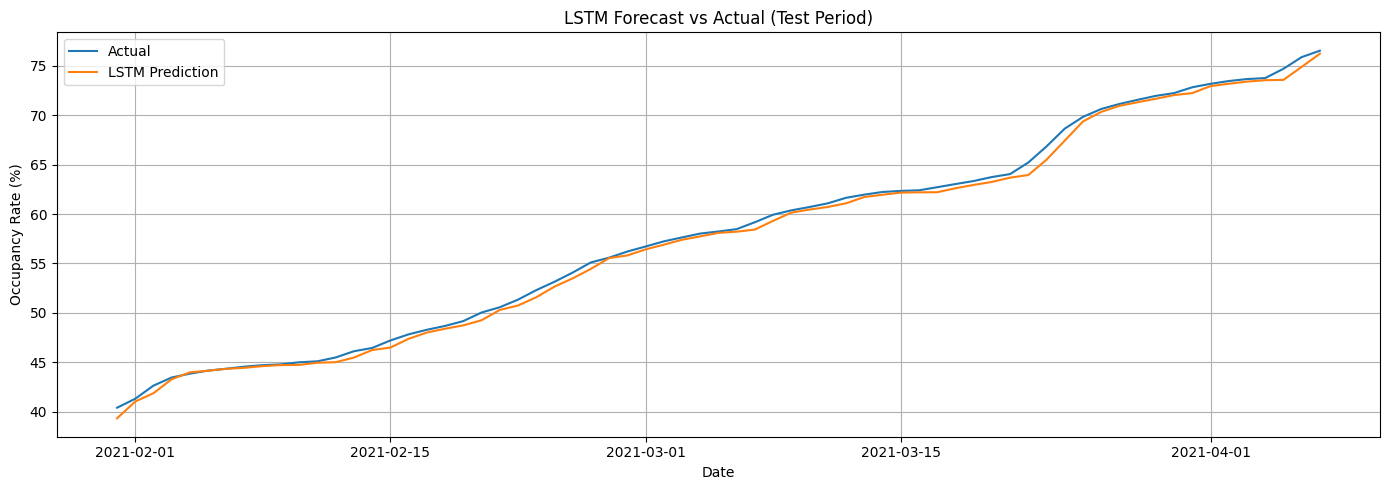

In [4]:
# Importing necessary libraries for LSTM modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Loading the cleaned dataset
df = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df['DATE'] = pd.to_datetime(df['DATE'])

# Defining train-test split
split_date = '2021-01-01'
df_train = df[df['DATE'] < split_date]
df_test = df[df['DATE'] >= split_date]

# Using only the occupancy rate
train_values = df_train['GENERAL_DAM_OCCUPANCY_RATE'].values.reshape(-1,1)
test_values = df_test['GENERAL_DAM_OCCUPANCY_RATE'].values.reshape(-1,1)

# Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# Preparing data for LSTM (using 30 previous steps)
def create_sequences(data, look_back=30):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

# Building the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Predicting on the test set
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Calculating error metrics
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))

print(f"LSTM MAE (Test Set): {mae:.2f}")
print(f"LSTM RMSE (Test Set): {rmse:.2f}")

# Plotting actual vs predicted
plt.figure(figsize=(14,5))
plt.plot(df_test['DATE'][30:], y_test_inverse.flatten(), label='Actual')
plt.plot(df_test['DATE'][30:], predictions_inverse.flatten(), label='LSTM Prediction')
plt.title('LSTM Forecast vs Actual (Test Period)')
plt.xlabel('Date')
plt.ylabel('Occupancy Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
